In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
seed=10

In [2]:
client_train_data = pd.read_csv('archive/client_train.csv')
client_test_data  = pd.read_csv('archive/client_test.csv')
invoice_train_data = pd.read_csv('archive/invoice_train.csv')
invoice_test_data = pd.read_csv('archive/invoice_test.csv')

/Users/chuene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# shape of the data
print(client_train_data.shape, client_test_data.shape, invoice_train_data.shape, invoice_test_data.shape)

(135493, 6) (58069, 5) (4476749, 16) (1939730, 16)


In [4]:
print('Number of missing rows in invoice_train_data:',invoice_train_data.isna().sum().sum())
print('Number of missing rows in invoice_test_data:',invoice_test_data.isna().sum().sum(),'\n')
print('Number of missing rows in client_train_data:',client_train_data.isna().sum().sum())
print('Number of missing rows in client_test_data:',client_test_data.isna().sum().sum())

Number of missing rows in invoice_train_data: 0
Number of missing rows in invoice_test_data: 0 

Number of missing rows in client_train_data: 0
Number of missing rows in client_test_data: 0


In [5]:
print('Number of unique values in invoice_train_data:')
for col in invoice_train_data.columns:
    print(f"{col} - {invoice_train_data[col].nunique()}")

Number of unique values in invoice_train_data:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


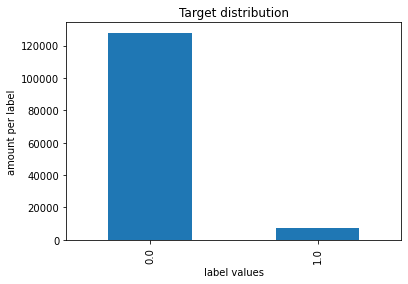

In [6]:
client_train_data.groupby(['target'])['client_id'].count().plot(kind='bar')
plt.title('Target distribution')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

In [8]:
def cleaning_invoice_train_data(df):
    le  = LabelEncoder()
    #invoice_train_data['counter_type_encoded'] = invoice_train_data['counter_type'].map({"ELEC":1,"GAZ":0})
    invoice_train_data['counter_type_encoded'] = le.fit_transform(invoice_train_data['counter_type'])
    invoice_train_data['counter_statue'] = invoice_train_data['counter_statue'].map(
                                {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 769:5, '0':0, 
                                 '5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5
                                })
    
    return invoice_train_data
    

In [9]:
def cleaning_invoice_test_data(df):
    le  = LabelEncoder()
    #invoice_train_data['counter_type_encoded'] = invoice_train_data['counter_type'].map({"ELEC":1,"GAZ":0})
    invoice_test_data['counter_type_encoded'] = le.fit_transform(invoice_test_data['counter_type'])
    invoice_test_data['counter_statue'] = invoice_test_data['counter_statue'].map(
                                {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 769:5, '0':0, 
                                 '5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5
                                })
    
    return invoice_test_data
    

In [10]:
def create_datetime_train_features(df):
    
    invoice_train_data['invoice_date'] = pd.to_datetime(invoice_train_data['invoice_date'], dayfirst=True)
    invoice_train_data['invoice_day'] = invoice_train_data['invoice_date'].dt.day
    invoice_train_data['invoice_month'] = invoice_train_data['invoice_date'].dt.month
    invoice_train_data['invoice_year'] = invoice_train_data['invoice_date'].dt.year
    
    return invoice_train_data

In [11]:
def create_datetime_test_features(df):
    
    invoice_test_data['invoice_date'] = pd.to_datetime(invoice_test_data['invoice_date'], dayfirst=True)
    invoice_test_data['invoice_day'] = invoice_test_data['invoice_date'].dt.day
    invoice_test_data['invoice_month'] = invoice_test_data['invoice_date'].dt.month
    invoice_test_data['invoice_year'] = invoice_test_data['invoice_date'].dt.year
    
    return invoice_test_data

In [14]:
clean_invoice = cleaning_invoice_train_data(invoice_train_data)

In [15]:
invoice_train = create_datetime_train_features(clean_invoice)
invoice_train

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,counter_type_encoded,invoice_day,invoice_month,invoice_year
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,0,24,3,2014
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,0,29,3,2013
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,0,23,3,2015
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,0,13,7,2015
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,0,17,11,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC,0,19,8,2005
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC,0,19,12,2005
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC,0,25,9,1996
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC,0,28,5,1996


In [16]:
invoice_train.counter_type_encoded.unique()

array([0, 1])

In [17]:

def merge_client_and_invoice_train_info(client_data, invoice_data):
    """
    
    
    """
    
    merged_train_data = client_train_data.merge(
                                    invoice_train, left_on='client_id',
                                    right_on='client_id', how='left'
                                ).drop(['counter_type', 'client_id', 'invoice_date'], axis=1)
    
    merged_train_data['creation_datetime'] =  pd.to_datetime(
                                            merged_train_data['creation_date']
                                        ).apply(lambda x: x.toordinal())

    merged_train_data = merged_train_data.drop(['creation_date'], axis=1)
    
    return merged_train_data

train_data = merge_client_and_invoice_train_info(client_train_data, invoice_train)
train_data

,disrict,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,...,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type_encoded,invoice_day,invoice_month,invoice_year,creation_datetime
0,60,11,101,0.0,11,1335667,0,203,8,1,...,0,0,14302,14384,4,0,24,3,2014,728293
1,60,11,101,0.0,11,1335667,0,203,6,1,...,0,0,12294,13678,4,0,29,3,2013,728293
2,60,11,101,0.0,11,1335667,0,203,8,1,...,0,0,14624,14747,4,0,23,3,2015,728293
3,60,11,101,0.0,11,1335667,0,207,8,1,...,0,0,14747,14849,4,0,13,7,2015,728293
4,60,11,101,0.0,11,1335667,0,207,9,1,...,0,0,15066,15638,12,0,17,11,2016,728293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,60,11,101,0.0,10,1253571,0,202,9,1,...,0,0,3197,3732,8,0,19,8,2005,727919
4476745,60,11,101,0.0,10,1253571,0,202,6,1,...,0,0,3732,3938,4,0,19,12,2005,727919
4476746,60,11,101,0.0,11,560948,0,203,6,1,...,0,0,13884,14143,4,0,25,9,1996,725055
4476747,60,11,101,0.0,11,560948,0,203,6,1,...,0,0,13281,13884,4,0,28,5,1996,725055


In [18]:
clean_invoice = cleaning_invoice_test_data(invoice_test_data)

In [19]:
invoice_test = create_datetime_test_features(clean_invoice)
invoice_test

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,counter_type_encoded,invoice_day,invoice_month,invoice_year
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC,0,16,3,2018
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC,0,21,3,2014
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC,0,17,7,2014
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC,0,13,7,2015
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC,0,19,7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939725,test_Client_9999,2010-03-11,11,869269,0,203,6,1,248,0,0,0,21114,21362,4,ELEC,0,11,3,2010
1939726,test_Client_9999,2011-03-15,11,869269,0,203,6,1,260,0,0,0,21362,21622,4,ELEC,0,15,3,2011
1939727,test_Client_9999,2012-12-03,11,869269,0,203,6,1,312,0,0,0,22272,22584,4,ELEC,0,3,12,2012
1939728,test_Client_9999,2009-07-01,11,869269,0,203,6,1,236,0,0,0,19909,20145,4,ELEC,0,1,7,2009


In [20]:
def merge_client_and_invoice_test_info(client_data, invoice_data):
    """
    
    
    """
    
    merged_test_data = client_test_data.merge(
                                    invoice_test, left_on='client_id',
                                    right_on='client_id', how='left'
                                ).drop(['counter_type', 'client_id', 'invoice_date'], axis=1)
    
    merged_test_data['creation_datetime'] =  pd.to_datetime(
                                            merged_test_data['creation_date']
                                        ).apply(lambda x: x.toordinal())

    merged_test_data = merged_test_data.drop(['creation_date'], axis=1)
    
    return merged_test_data

test_data = merge_client_and_invoice_test_info(client_test_data, invoice_test)
test_data

,disrict,client_catg,region,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,...,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type_encoded,invoice_day,invoice_month,invoice_year,creation_datetime
0,62,11,307,11,651208,0,203,8,1,755,...,0,0,19145,19900,8,0,16,3,2018,730998
1,62,11,307,11,651208,0,203,8,1,1067,...,0,0,13725,14792,8,0,21,3,2014,730998
2,62,11,307,11,651208,0,203,8,1,0,...,0,0,14792,14792,4,0,17,7,2014,730998
3,62,11,307,11,651208,0,203,9,1,410,...,0,0,16122,16532,4,0,13,7,2015,730998
4,62,11,307,11,651208,0,203,9,1,412,...,0,0,17471,17883,4,0,19,7,2016,730998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939725,69,11,104,11,869269,0,203,6,1,248,...,0,0,21114,21362,4,0,11,3,2010,726540
1939726,69,11,104,11,869269,0,203,6,1,260,...,0,0,21362,21622,4,0,15,3,2011,726540
1939727,69,11,104,11,869269,0,203,6,1,312,...,0,0,22272,22584,4,0,3,12,2012,726540
1939728,69,11,104,11,869269,0,203,6,1,236,...,0,0,19909,20145,4,0,1,7,2009,726540


/Users/chuene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='invoice_month'>

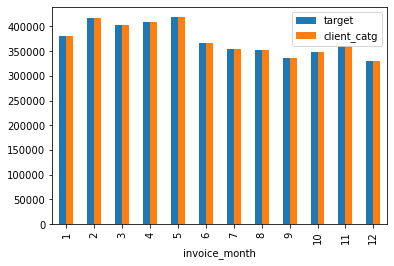

In [21]:
train_data.groupby('invoice_month')['target','client_catg'].count().plot(kind='bar')

<AxesSubplot:xlabel='invoice_month'>

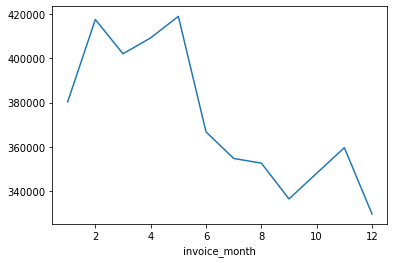

In [22]:
train_data.groupby('invoice_month')['target'].count().plot()

In [23]:
X_train_data = train_data.drop(['target'], axis=1)
y_train_data = train_data['target']

In [28]:
smote = SMOTE(random_state = 14)
X_train, y_train = smote.fit_sample(X_train_data, y_train_data)

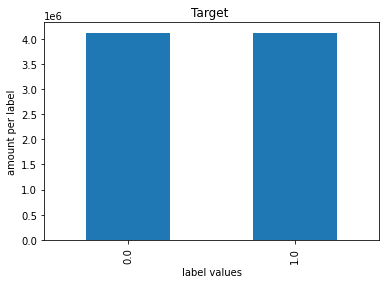

In [29]:
y_train.value_counts().plot(kind='bar')
plt.title('Target ')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

In [25]:
X_train = X_train_data
y_train = y_train_data

In [34]:
model = LGBMClassifier(random_state=seed, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

#model = LogisticRegression()

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train)
                 #eval_set=[(X_train, y_train), (X_valid, y_valid)])
                 #early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_data)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [ ]:
%%time
probs = calc(X_train, y_train, model, stkfold)